In [1]:
from zipline.api import order_target, record, symbol
from zipline.finance import commission
from datetime import datetime
import pytz

In [2]:
def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')
    context.set_commission(commission.PerShare(cost=0.0075, min_trade_cost=1.0))

def handle_data(context, data):
    # Skip first 30 days to get full windows
    context.i += 1
    if context.i < 30:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=10, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=30, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)
    
def analyze(context, perf):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.ix[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.ix[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

In [3]:
from zipline.algorithm import TradingAlgorithm
from pyEXzipline import load_from_iex

In [4]:
algo = TradingAlgorithm(handle_data=handle_data, initialize=initialize, analyze=analyze)

In [5]:
start = datetime(2016, 12, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 6, 1, 0, 0, 0, 0, pytz.utc)
data = load_from_iex(['aapl'], start, end)

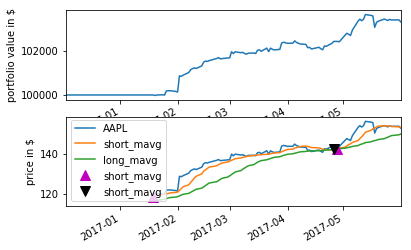

In [6]:
%matplotlib inline
results = algo.run(data)